In [1]:
import pandas as pd
from math import isnan
import matplotlib as mpl
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pickle as pkl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
mpl.rcParams['figure.dpi'] = 300

In [2]:
import sys
sys.path.append("..")
import sensei

In [3]:
import tcga_dicts
from tcga_dicts import *

In [10]:
inf = float('inf')

In [4]:
immune_subtypes = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
immune_subtype_dict = {
    'C1': 'wound healing', 
    'C2': 'IFN-γ dominant', 
    'C3': 'inflammatory', 
    'C4': 'lymphocyte depleted', 
    'C5': 'immunologically quiet', 
    'C6': 'TGF-β dominant'
}

# Load Data

Load in data from Supplmentary Table 2 from Thorsson et al. [_The Immune Landscape of Cancer_](https://doi.org/10.1016/j.immuni.2018.03.023).

In [5]:
data = pd.read_excel("1-s2.0-S1074761318301213-mmc2.xlsx")
data

,TCGA Participant Barcode,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
0,TCGA-01-0639,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0007,GBM,NaN,GBM_LGG.Classic-like,0.047660,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0011,GBM,NaN,GBM_LGG.LGm6-GBM,0.062099,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0023,GBM,NaN,GBM_LGG.,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0025,GBM,NaN,GBM_LGG.,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11075,TCGA-ZJ-AAXJ,CESC,C2,NaN,0.190520,0.28,0.06,3.508290,1.0591,0.4380,...,0.109746,0.158487,0.053922,0.025416,0.588338,0.001046,0.0,0.016717,0.218868,0.175031
11076,TCGA-ZJ-AB0I,CESC,C2,NaN,0.059910,0.10,0.03,2.915626,0.9968,0.3120,...,0.227673,0.082950,0.000000,0.050475,0.475620,0.001589,0.0,0.082539,0.028535,0.411717
11077,TCGA-ZN-A9VU,MESO,C2,NaN,0.272642,0.39,0.01,NaN,-0.4574,-0.1410,...,0.074590,0.049620,0.000000,0.000000,0.470148,0.000000,0.0,0.123572,0.027675,0.378605
11078,TCGA-ZN-A9VW,MESO,C6,NaN,0.286224,0.35,0.01,NaN,0.4057,0.0475,...,0.236810,0.076568,0.000000,0.046645,0.426932,0.000000,0.0,0.002948,0.003850,0.566270


Remove invalid rows.

In [6]:
data = data[data['Immune Subtype'].apply(lambda x: x in immune_subtypes)]
data

,TCGA Participant Barcode,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
9,TCGA-02-2485,GBM,C4,GBM_LGG.Classic-like,0.049501,0.13,0.03,NaN,0.3223,0.1500,...,0.015523,0.198057,0.054341,0.000000,0.396934,0.000000,0.011272,0.094994,0.000000,0.496801
13,TCGA-05-4410,LUAD,C3,LUAD.3,0.428618,0.76,0.39,0.000000,-0.2923,-0.1660,...,0.109387,0.013077,0.000000,0.013376,0.726240,0.003574,0.000000,0.023075,0.000000,0.247111
14,TCGA-05-4424,LUAD,C2,LUAD.5,0.326200,0.76,0.45,4.438672,0.3447,0.0200,...,0.055662,0.026872,0.000000,0.008113,0.423194,0.012312,0.000000,0.033189,0.003214,0.528092
15,TCGA-05-4425,LUAD,C6,LUAD.4,0.228394,0.39,0.08,0.000000,-0.0918,-0.0170,...,0.052170,0.014315,0.000000,0.050522,0.325964,0.000000,0.000000,0.030454,0.033241,0.610342
17,TCGA-06-0156,GBM,C4,GBM_LGG.,NaN,NaN,NaN,NaN,0.4888,0.1380,...,0.096720,0.022861,0.000000,0.000000,0.322847,0.079236,0.000000,0.082228,0.000142,0.515548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11075,TCGA-ZJ-AAXJ,CESC,C2,NaN,0.190520,0.28,0.06,3.508290,1.0591,0.4380,...,0.109746,0.158487,0.053922,0.025416,0.588338,0.001046,0.000000,0.016717,0.218868,0.175031
11076,TCGA-ZJ-AB0I,CESC,C2,NaN,0.059910,0.10,0.03,2.915626,0.9968,0.3120,...,0.227673,0.082950,0.000000,0.050475,0.475620,0.001589,0.000000,0.082539,0.028535,0.411717
11077,TCGA-ZN-A9VU,MESO,C2,NaN,0.272642,0.39,0.01,NaN,-0.4574,-0.1410,...,0.074590,0.049620,0.000000,0.000000,0.470148,0.000000,0.000000,0.123572,0.027675,0.378605
11078,TCGA-ZN-A9VW,MESO,C6,NaN,0.286224,0.35,0.01,NaN,0.4057,0.0475,...,0.236810,0.076568,0.000000,0.046645,0.426932,0.000000,0.000000,0.002948,0.003850,0.566270


TCGA Study,ACC,BLCA,BRCA,CESC,CHOL,COAD,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,UCEC,UCS,UVM
Immune Subtype,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1,1,173,369,77,7,332,71,3,128,2,7,3,0,22,83,275,32,46,57,0,35,127,64,41,129,42,2,247,41,0
C2,1,164,391,217,2,85,87,0,379,0,20,4,0,45,147,182,21,159,32,1,18,18,38,27,210,104,13,212,14,0
C3,23,21,191,0,17,9,7,0,2,38,445,202,10,135,179,8,8,3,40,107,307,9,42,14,36,2,460,52,0,30
C4,49,36,92,6,8,12,6,150,2,12,27,66,147,159,20,7,11,61,1,63,45,1,59,19,9,1,22,16,2,48
C5,3,0,0,0,0,0,0,1,0,13,3,2,356,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,2
C6,1,3,40,0,1,3,2,0,3,0,13,2,1,1,28,14,11,0,21,2,0,1,20,2,7,0,3,1,0,0


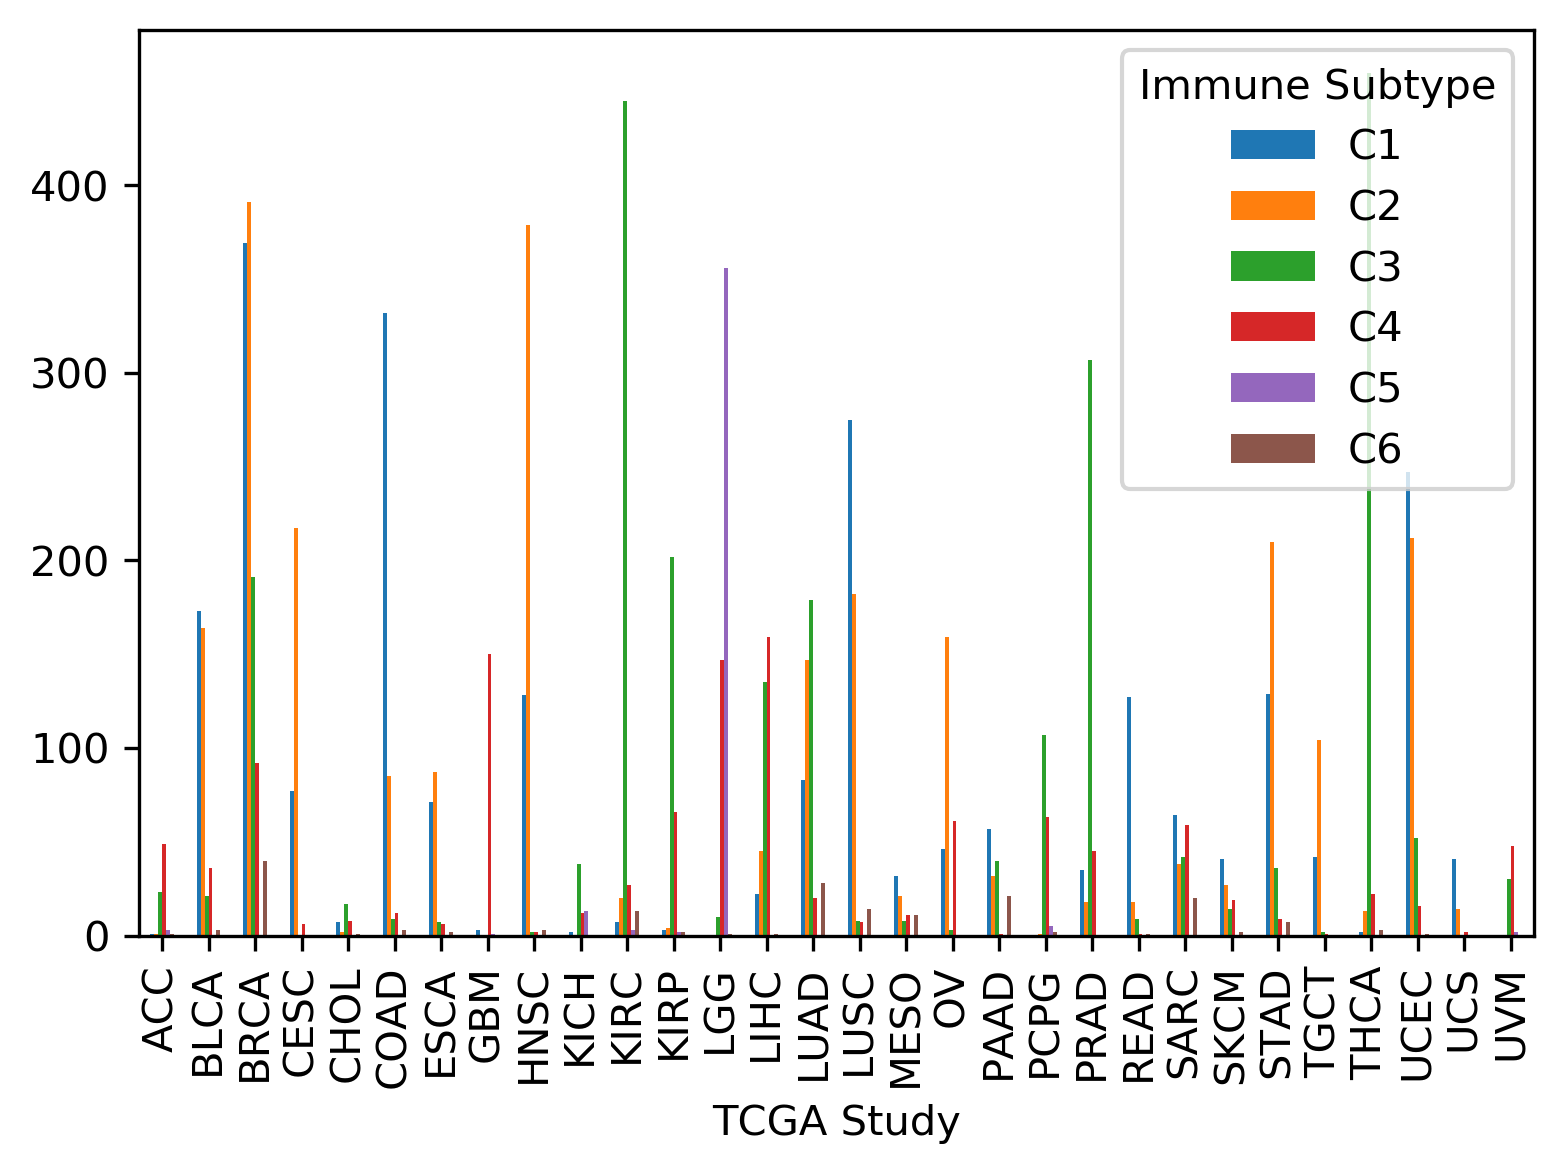

In [8]:
info = pd.crosstab(data['TCGA Study'], data['Immune Subtype'])
display(info.T.style)
display(info.plot(kind='bar'))

# Calculation

In [101]:
plot_cancer_types = info.index.tolist() #['BRCA', 'COAD', 'LGG']
plot_cell_types = [
    "T Cells CD8", # For C2 and C3
    "Monocytes", # For C5
    "Macrophages M0", # For C1
    "Macrophages M1", # For C2
    "Macrophages M2", # For C5
    "T Cells CD4 Memory Resting", # For C3 and C6
]

plot_cell_type_dict = {
    "T Cells CD8": "CD8 T", 
    "Monocytes": "Monocytes", 
    "Macrophages M0": "M0 Macrophages", 
    "Macrophages M1": "M1 Macrophages", 
    "Macrophages M2": "M2 Macrophages", 
    "T Cells CD4 Memory Resting": "Resting CD4 $\mathregular{T_{M}}$"
}

def plot_cell_type_map(x):
    if x in plot_cell_type_dict:
        return plot_cell_type_dict[x]
    else:
        return x

plot_cell_numbers = [100, 384, 1000, inf]

max_sample_size = 10000

beta = 0.2

In [59]:
result = {cancer_type: {immune_subtype: pd.DataFrame(index=plot_cell_numbers, columns=plot_cell_types)
                        for immune_subtype in immune_subtypes
                       } 
          for cancer_type in plot_cancer_types}

effect = {cancer_type: pd.DataFrame(index=immune_subtypes, columns=plot_cell_types) for cancer_type in plot_cancer_types}

for cancer_type in plot_cancer_types:
    for immune_subtype in immune_subtypes:
        data_mask = (data['Immune Subtype'] == immune_subtype) & (data['TCGA Study'] == cancer_type)
        
        if data_mask.sum() < 10: continue
            
        one_data = data[data_mask]
        other_data = data[~data_mask]
        
        for cell_type in plot_cell_types:
            one_mean = one_data[cell_type].mean()
            other_mean = other_data[cell_type].mean()

            one_sd = one_data[cell_type].std() # sample sd ("N - 1") by default
            other_sd = other_data[cell_type].std()

            effect[cancer_type].loc[immune_subtype, cell_type] = one_mean - other_mean
            
            for cell_number in plot_cell_numbers:
                
                sample_sizes = [sensei.optimize.find_minimum_M(max_sample_size, cell_number,  
                                                               [one_mean, other_mean], 
                                                               [one_sd, other_sd], 
                                                               beta=beta, 
                                                               design='unpaired' + ('-baseline' if cell_number == float('inf') else '')) 
                                for cell_number in plot_cell_numbers]
                result[cancer_type][immune_subtype][cell_type] = sample_sizes

In [60]:
display(effect['BRCA'])
for immune_subtype in immune_subtypes:
    print(immune_subtype)
    display(result['BRCA'][immune_subtype])

,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
C1,-0.0195732,-0.0253184,0.051519,0.00985838,0.0182856,-0.000888049
C2,-0.00603101,-0.0261955,0.0225072,0.0418016,-0.0193118,0.0238767
C3,-0.0083098,-0.0193167,-0.0329732,0.00407413,0.00616532,0.0387573
C4,-0.0524243,-0.0174571,0.0601233,-0.0211085,0.151075,-0.0268521
C5,NaN,NaN,NaN,NaN,NaN,NaN
C6,-0.028374,-0.0225984,0.0482304,0.00153102,0.0705832,0.00916778


C1


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,186,35,72,267,637,NaN
384.0,164,31,69,222,587,NaN
1000.0,160,30,69,213,576,NaN
inf,157,30,68,207,569,NaN


C2


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,2106,32,293,20,576,155
384.0,1870,29,281,17,533,140
1000.0,1819,28,278,16,524,137
inf,1787,28,277,15,518,135


C3


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,1034,63,105,1484,5764,59
384.0,911,56,101,1236,5333,53
1000.0,884,55,101,1182,5240,52
inf,867,54,100,1149,5181,51


C4


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,26,75,58,49,13,107
384.0,23,67,56,42,12,97
1000.0,22,65,56,41,12,95
inf,22,64,55,40,12,93


C5


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,NaN,NaN,NaN,NaN,NaN,NaN
384.0,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,NaN,NaN,NaN,NaN,NaN,NaN
inf,NaN,NaN,NaN,NaN,NaN,NaN


C6


,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,90,43,74,9644,54,1019
384.0,80,38,71,7925,50,921
1000.0,78,38,71,7552,49,899
inf,77,37,70,7319,49,886


In [81]:
result['LGG']['C5']

,T Cells CD8,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,T Cells CD4 Memory Resting
100.0,13,7,15,10,10,49
384.0,12,7,14,9,10,44
1000.0,12,6,14,9,9,44
inf,11,6,14,9,9,43


# Plotting

Text(0.5, 0.08, 'Estimated sample size to ascertain changes between a immune subtype and all others with 80% power')

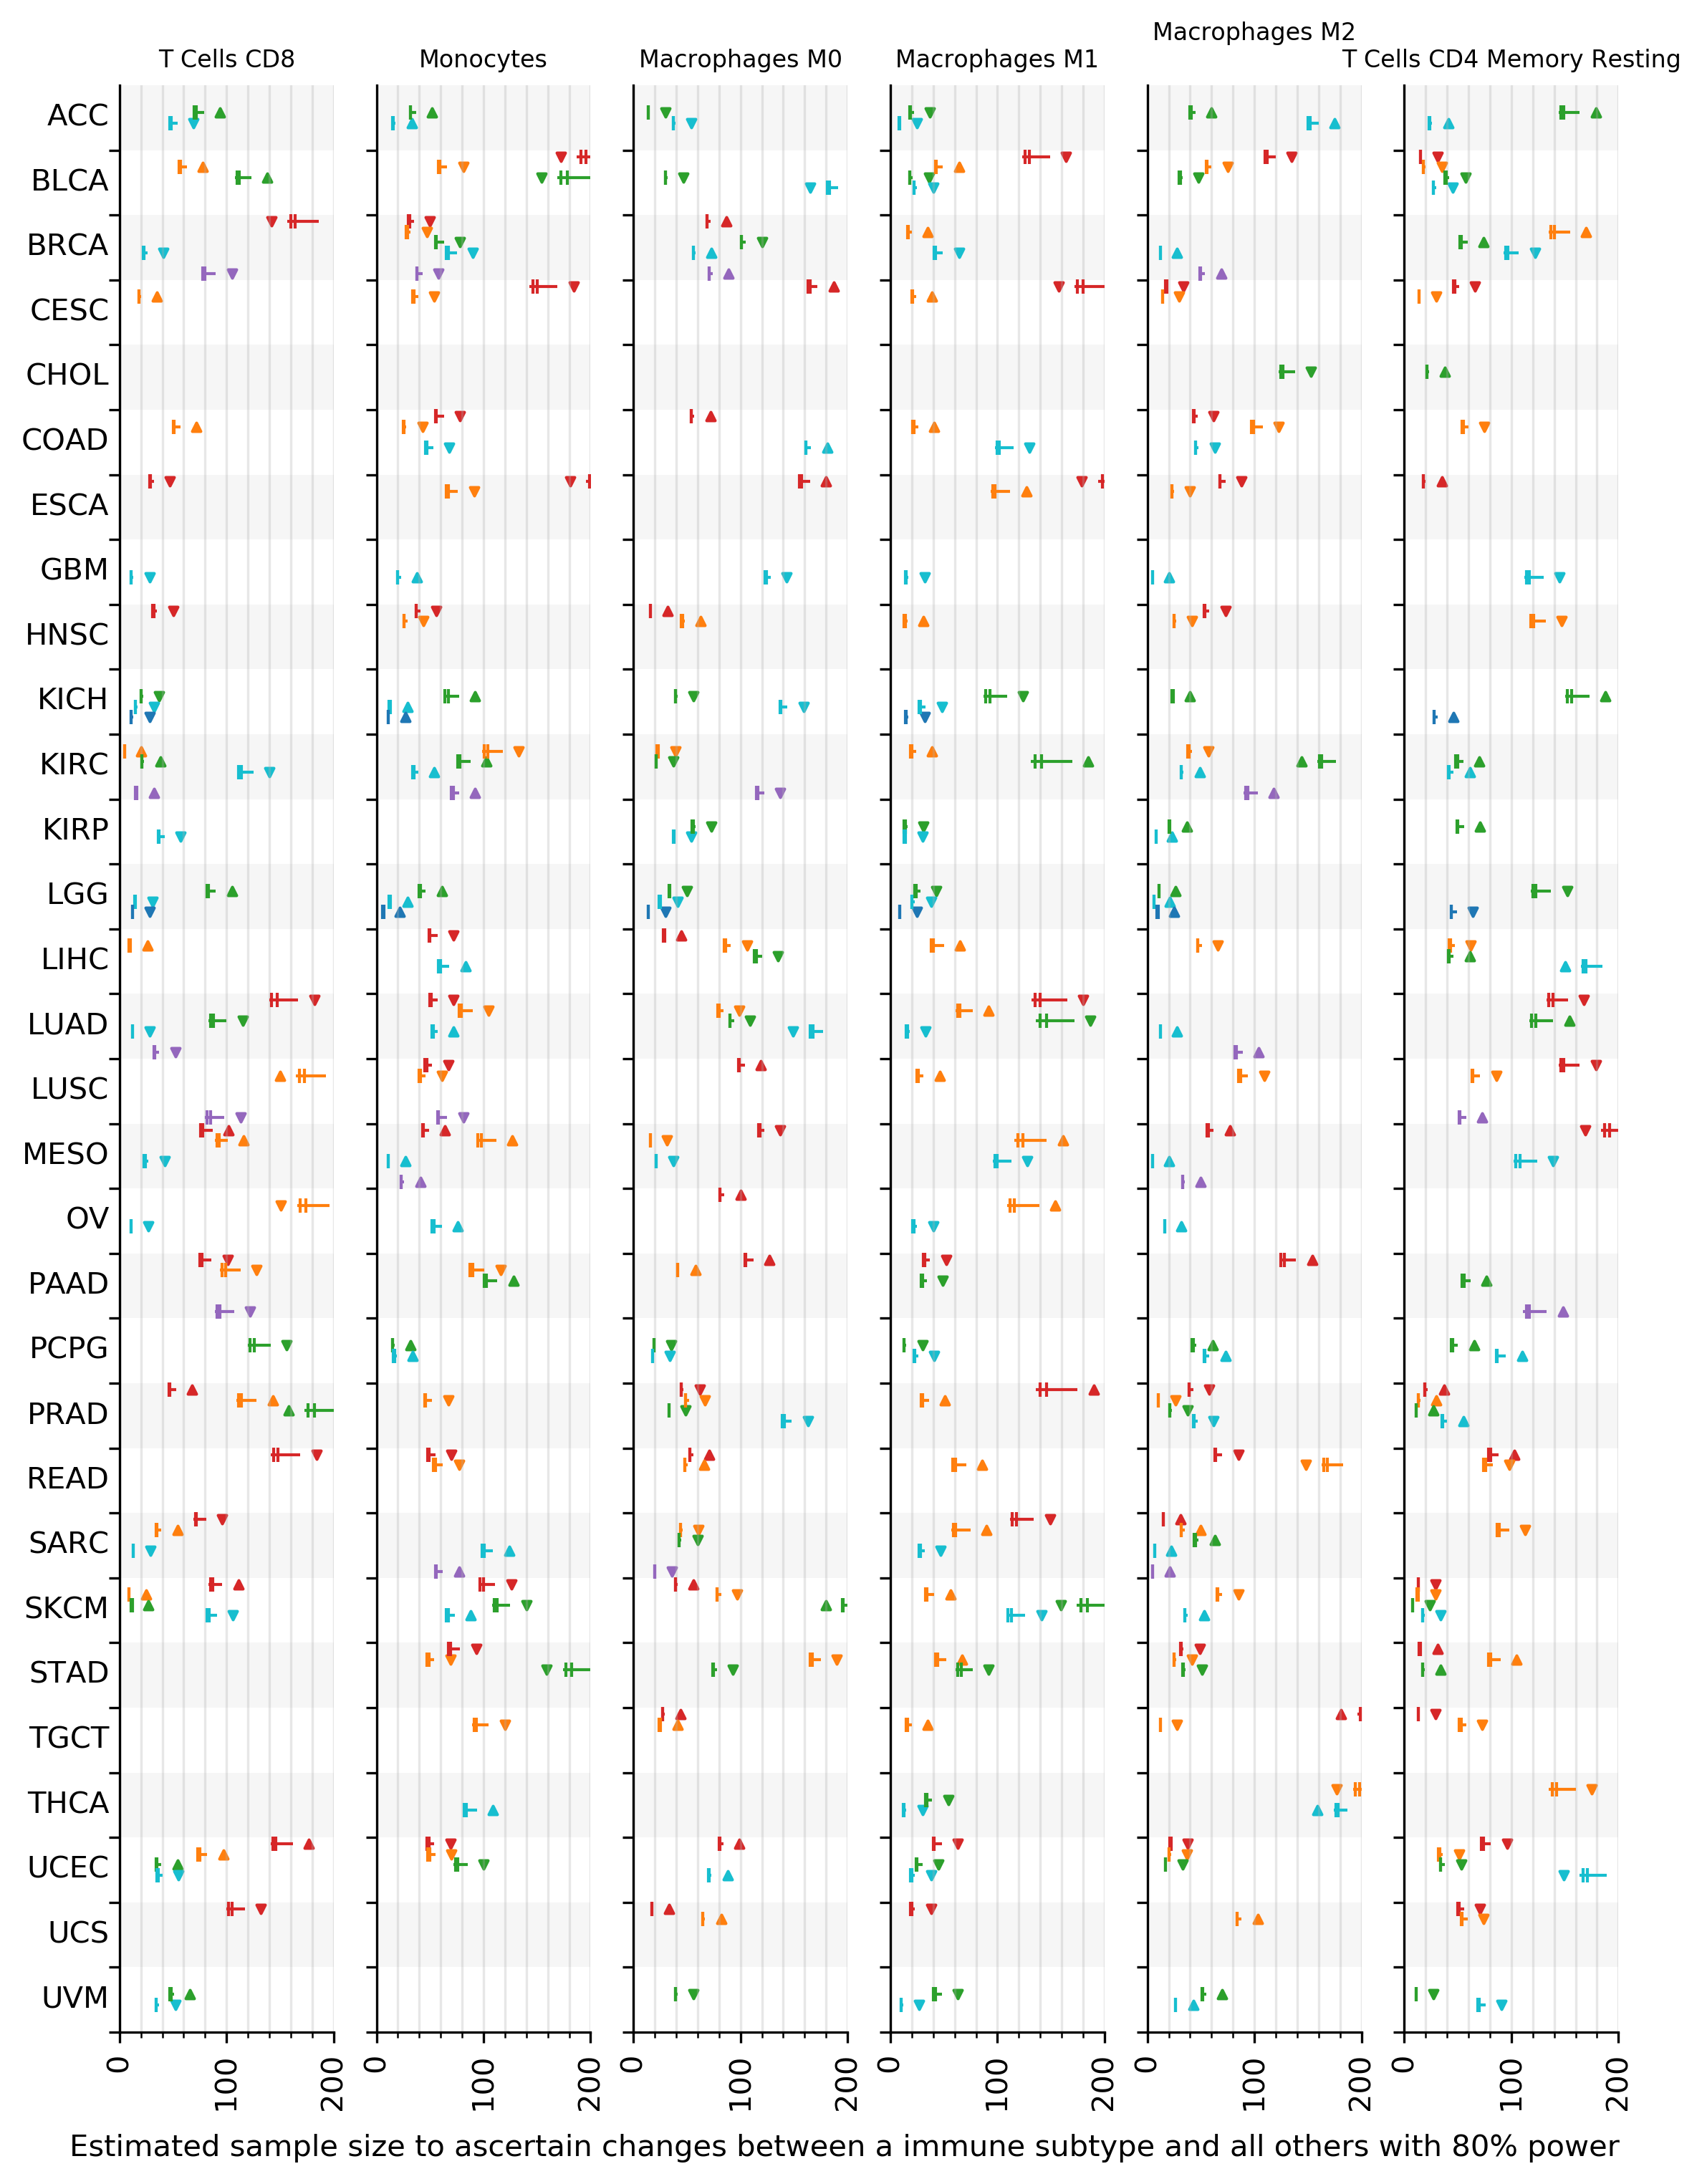

In [68]:
n_cancer_types = len(plot_cancer_types)

n_cell_types = len(plot_cell_types)

## Number is represented by error bar
upper_key = 100
center_key2 = 384
center_key = 1000
lower_key = float('inf')


## Immune subtypes by colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
immune_subtype_color_map = {
    'C1': colors[3], # red
    'C2': colors[1], # yellow/orange
    'C3': colors[2], # green
    'C4': colors[9], # cyan
    'C5': colors[0], # blue
    'C6': colors[4], # purple
}

immune_subtype_offset_map = {
    'C1': -0.40, # red
    'C2': -0.24, # yellow/orange
    'C3': -0.08, # green
    'C4': +0.08, # cyan
    'C5': +0.24, # blue
    'C6': +0.40, # purple
}

fig = plt.figure(figsize=(1.5 * n_cell_types, 0.4 * n_cancer_types))

axes = []

elinewidth = 1
ecolor = 'k'

for cell_type in plot_cell_types: # one column per cell type
    if len(axes) == 0:
        axes.append(fig.add_subplot(1, n_cell_types, 1))
    else:
        axes.append(fig.add_subplot(1, n_cell_types, len(axes) + 1, sharey = axes[0]))
        
    ax = axes[-1]
    
    for v in range(n_cancer_types):
        if v % 2 == 0:
            ax.fill_between([0, 1000], v - 0.5, v + 0.5, facecolor='lightgray', alpha=0.2)
    
    for i, cancer_type in enumerate(plot_cancer_types): # one row per cancer type
        for immune_subtype in immune_subtypes:
            y = i + immune_subtype_offset_map[immune_subtype]
            x_l = result[cancer_type][immune_subtype][cell_type][lower_key]
            x = result[cancer_type][immune_subtype][cell_type][center_key]
            x_u = result[cancer_type][immune_subtype][cell_type][upper_key]
            if x < 200:
                ax.errorbar(x, y, 
                            color=immune_subtype_color_map[immune_subtype], fmt='|', ms=5,
                            xerr=[[x - x_l], [x_u - x]], 
                            ecolor=immune_subtype_color_map[immune_subtype], elinewidth=elinewidth
                           )
                x = result[cancer_type][immune_subtype][cell_type][center_key2]
                ax.errorbar(x, y, color=immune_subtype_color_map[immune_subtype], fmt='|', ms=5)
            
                updown_marker = '^' if effect[cancer_type][cell_type][immune_subtype] > 0 else 'v'
                x = x_u + 15
                x = x_l - 15 if x > 190 else x
                ax.scatter(x, y, marker=updown_marker, color=immune_subtype_color_map[immune_subtype], s=8)
    
    ax.set_xlim([0, 200])
    ax.set_xticks([0, 100, 200])
    ax.set_xticks([20, 40, 60, 80, 120, 140, 160, 180], True)
    #ax.set_xscale('log')
    ax.grid(axis='x', which='both', alpha=0.3)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.tick_params(axis='y', which = 'both', labelleft=None)
    ax.tick_params(axis='y', which='minor', length=0)
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], rotation = 90, ha="center")
    ax.set_title(cell_type + ("\n" if cell_type == 'Macrophages M2' else ""), fontdict={'fontsize': 8})     
    
        
ax = axes[0]
ax.set_yticks(list(i for i in range(n_cancer_types)), True)
ax.set_yticks(list(i + 0.5 for i in range(n_cancer_types)))
ax.set_yticklabels("", va = 'center')
ax.set_yticklabels(plot_cancer_types, va = 'center', minor = True)
ax.tick_params(axis='y', which = 'both', labelleft=True)
ax.tick_params(axis='y', which='minor', length=0)
ax.set_ylim([-0.5, i + 0.5])
ax.invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.text(0.5, 0.08, 
         "Estimated sample size to ascertain changes between a immune subtype and all others with 80% power", 
         ha="center", va="center")

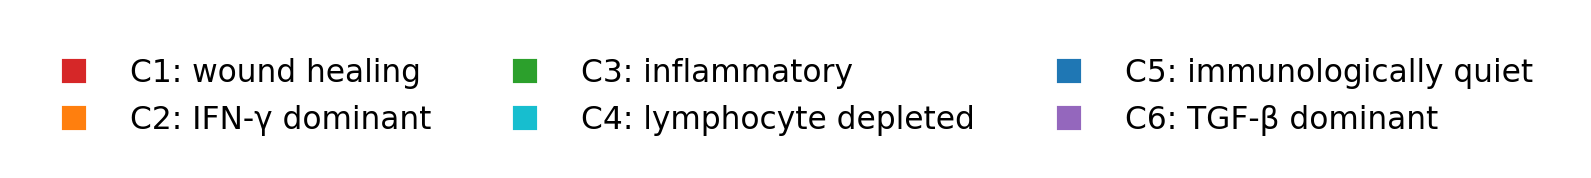

In [83]:
fig = plt.figure(figsize=(0.5, 0.5))
ax = fig.add_subplot(1, 1, 1)
legend_elements = [mpl.lines.Line2D([0], [0], 
                                    marker='s',
                                    ms=5,
                                    color=immune_subtype_color_map[i], 
                                    linestyle="None", 
                                    label= i + ': ' + immune_subtype_dict[i])
                                    for i in immune_subtype_color_map]
ax.legend(handles=legend_elements, loc='best', prop={'size': 7.5}, frameon=False, ncol=3)
ax.set_axis_off()

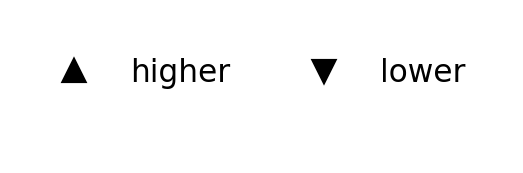

In [80]:
fig = plt.figure(figsize=(1, 0.5))
ax = fig.add_subplot(1, 1, 1)
legend_elements = [mpl.lines.Line2D([0], [0], marker='^', ms=5, color='k', linestyle="None", label='higher'),
                   mpl.lines.Line2D([0], [0], marker='v', ms=5, color='k', linestyle="None", label='lower')
                  ]

ax.legend(handles=legend_elements, loc='best', prop={'size': 7.5}, frameon=False, ncol=2)
ax.set_axis_off()

Text(0.5, 0.08, 'Estimated sample size to ascertain changes between a immune subtype and all others with 80% power')

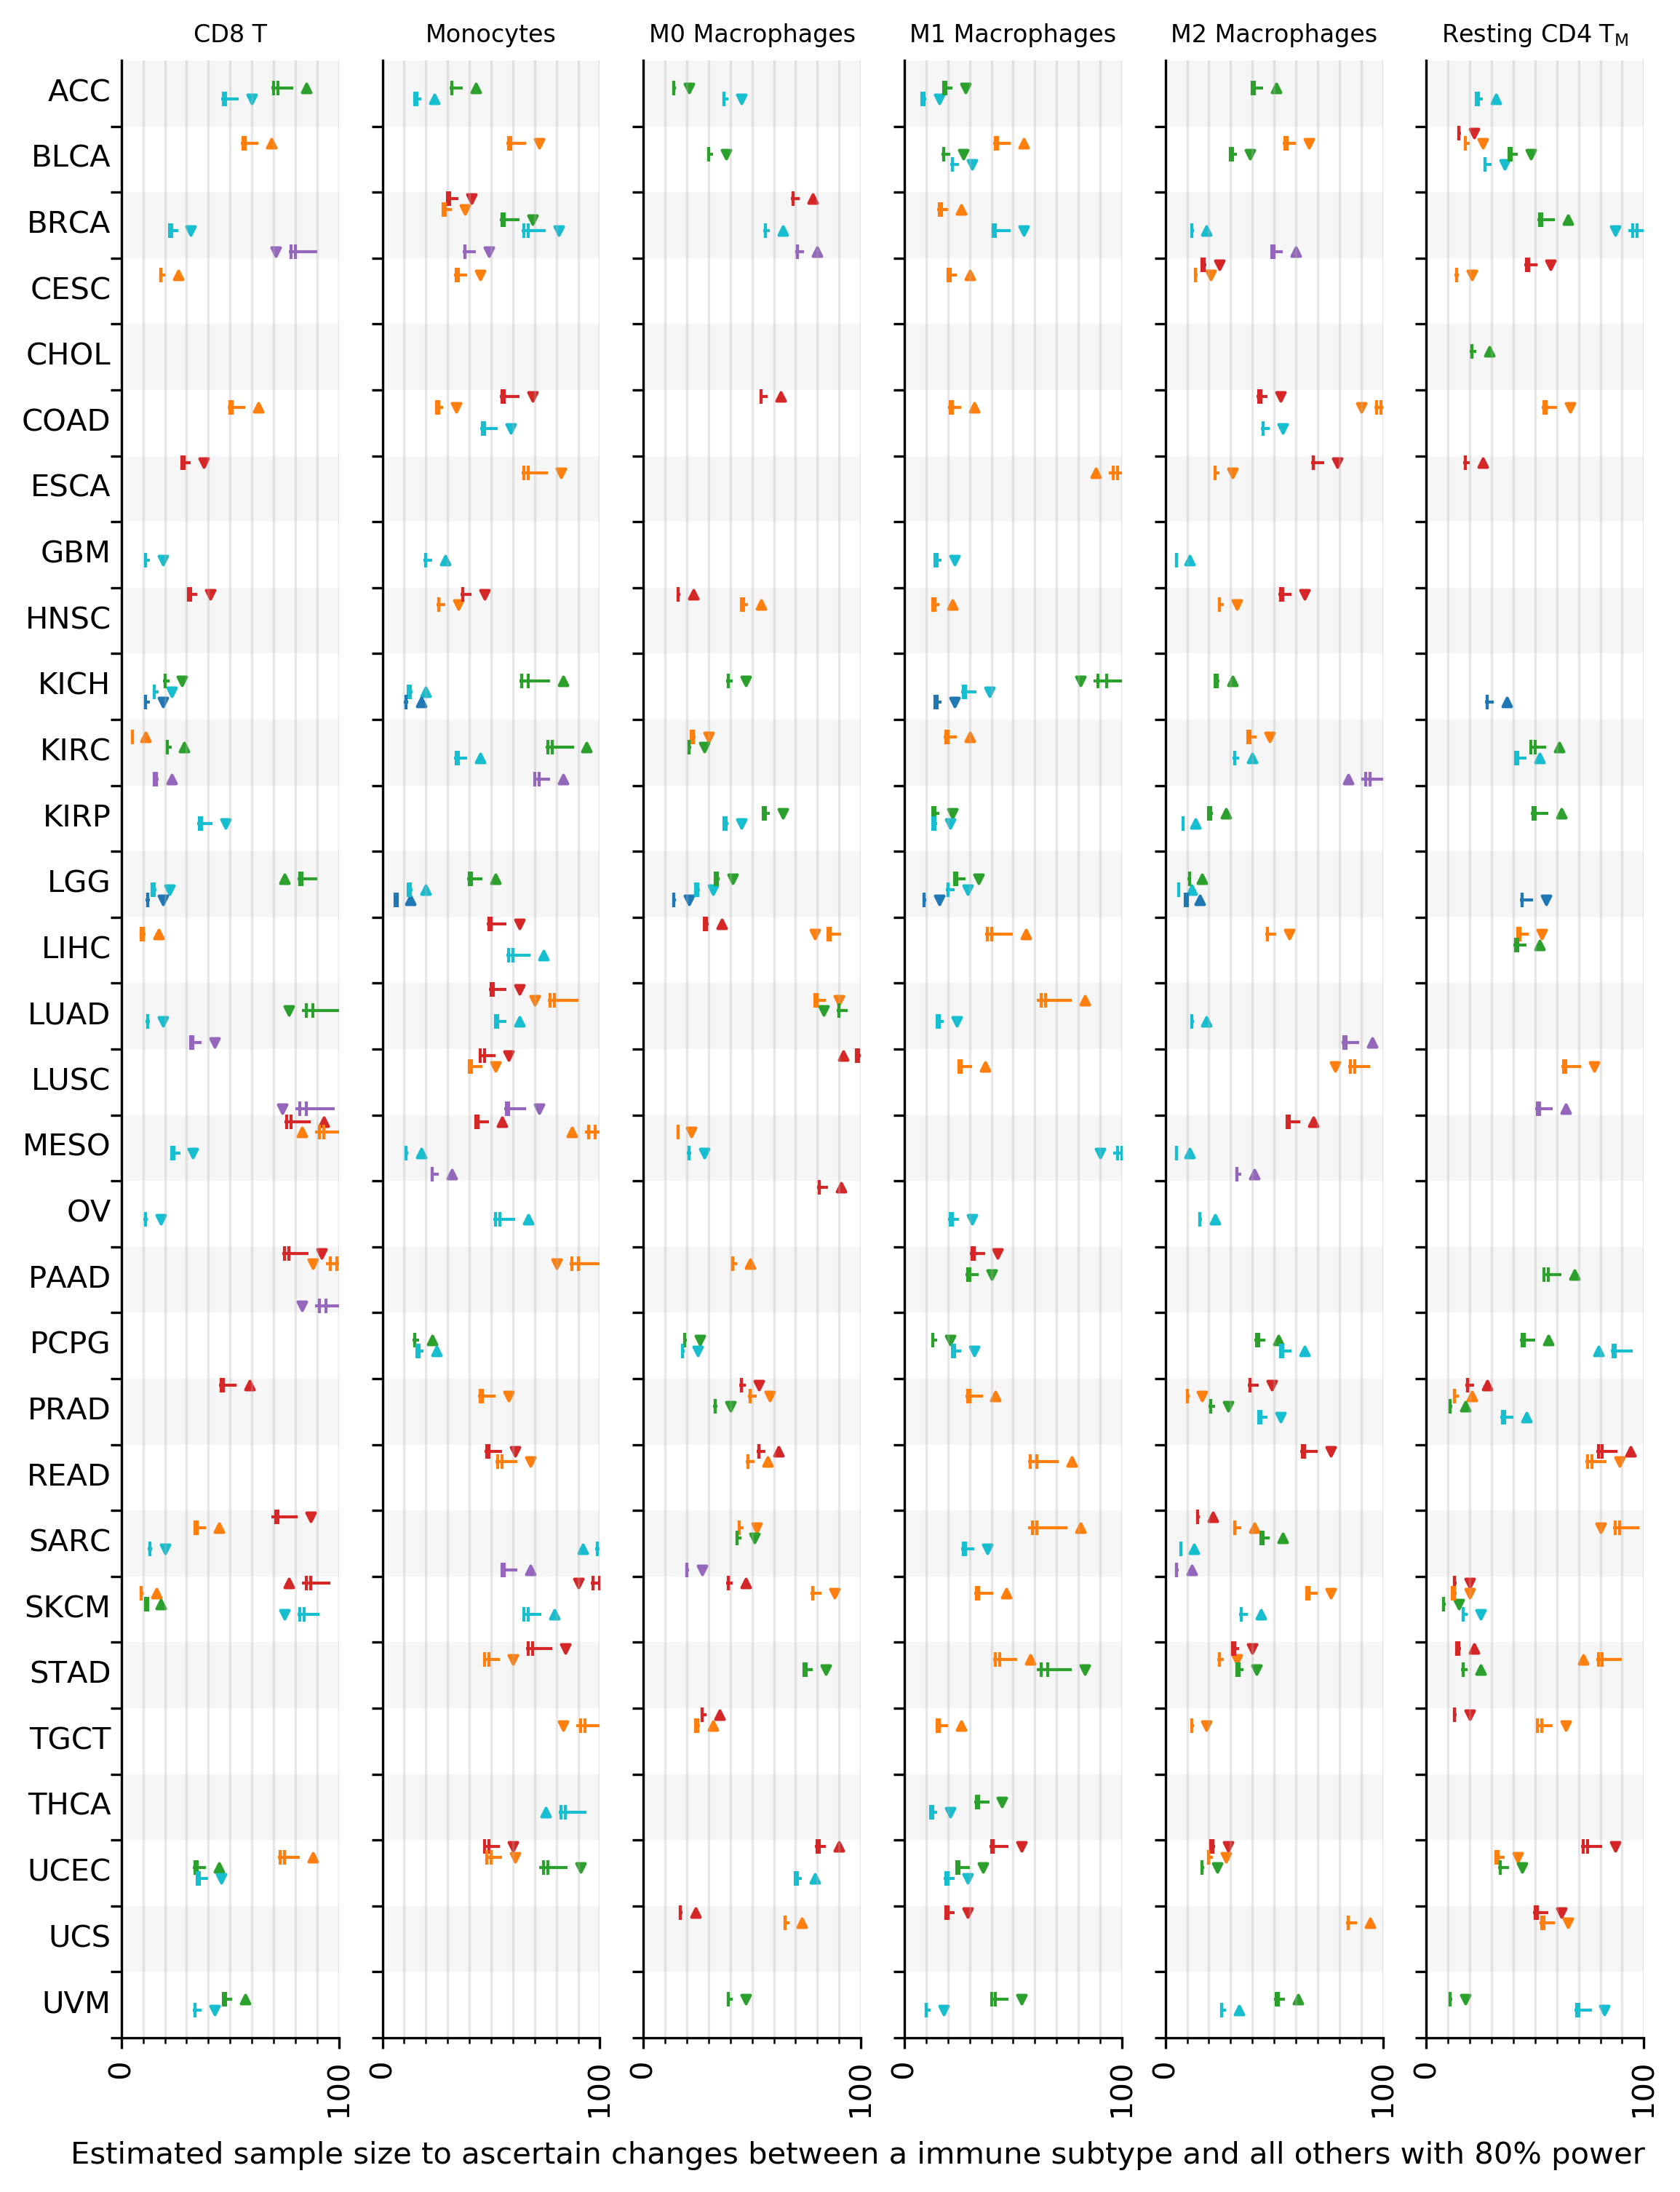

In [105]:
n_cancer_types = len(plot_cancer_types)

n_cell_types = len(plot_cell_types)

## Number is represented by error bar
upper_key = 100
center_key2 = 384
center_key = 1000
lower_key = float('inf')


## Immune subtypes by colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
immune_subtype_color_map = {
    'C1': colors[3], # red
    'C2': colors[1], # yellow/orange
    'C3': colors[2], # green
    'C4': colors[9], # cyan
    'C5': colors[0], # blue
    'C6': colors[4], # purple
}

immune_subtype_offset_map = {
    'C1': -0.40, # red
    'C2': -0.24, # yellow/orange
    'C3': -0.08, # green
    'C4': +0.08, # cyan
    'C5': +0.24, # blue
    'C6': +0.40, # purple
}

cell_type_dict = {
    ""
}

fig = plt.figure(figsize=(1.5 * n_cell_types, 0.4 * n_cancer_types))

axes = []

elinewidth = 1
ecolor = 'k'

for cell_type in plot_cell_types: # one column per cell type
    if len(axes) == 0:
        axes.append(fig.add_subplot(1, n_cell_types, 1))
    else:
        axes.append(fig.add_subplot(1, n_cell_types, len(axes) + 1, sharey = axes[0]))
        
    ax = axes[-1]
    
    for v in range(n_cancer_types):
        if v % 2 == 0:
            ax.fill_between([0, 1000], v - 0.5, v + 0.5, facecolor='lightgray', alpha=0.2)
    
    for i, cancer_type in enumerate(plot_cancer_types): # one row per cancer type
        for immune_subtype in immune_subtypes:
            y = i + immune_subtype_offset_map[immune_subtype]
            x_l = result[cancer_type][immune_subtype][cell_type][lower_key]
            x = result[cancer_type][immune_subtype][cell_type][center_key]
            x_u = result[cancer_type][immune_subtype][cell_type][upper_key]
            if x < 100:
                ax.errorbar(x, y, 
                            color=immune_subtype_color_map[immune_subtype], fmt='|', ms=5,
                            xerr=[[x - x_l], [x_u - x]], 
                            ecolor=immune_subtype_color_map[immune_subtype], elinewidth=elinewidth
                           )
                x = result[cancer_type][immune_subtype][cell_type][center_key2]
                ax.errorbar(x, y, color=immune_subtype_color_map[immune_subtype], fmt='|', ms=5)
            
                updown_marker = '^' if effect[cancer_type][cell_type][immune_subtype] > 0 else 'v'
                x = x_u + 6
                x = x_l - 6 if x > 95 else x
                ax.scatter(x, y, marker=updown_marker, color=immune_subtype_color_map[immune_subtype], s=8)
            # elif not isnan(effect[cancer_type][cell_type][immune_subtype]):
            #     updown_marker = '^' if effect[cancer_type][cell_type][immune_subtype] > 0 else 'v'
            #     ax.scatter(97, y, marker=updown_marker, color=immune_subtype_color_map[immune_subtype], s=8)
    
    ax.set_xlim([0, 100])
    ax.set_xticks([0, 100])
    ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 90], True)
    #ax.set_xscale('log')
    ax.grid(axis='x', which='both', alpha=0.3)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.tick_params(axis='y', which = 'both', labelleft=None)
    ax.tick_params(axis='y', which='minor', length=0)
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], rotation = 90, ha="center")
    ax.set_title(plot_cell_type_map(cell_type), fontdict={'fontsize': 8})     
    
        
ax = axes[0]
ax.set_yticks(list(i for i in range(n_cancer_types)), True)
ax.set_yticks(list(i + 0.5 for i in range(n_cancer_types)))
ax.set_yticklabels("", va = 'center')
ax.set_yticklabels(plot_cancer_types, va = 'center', minor = True)
ax.tick_params(axis='y', which = 'both', labelleft=True)
ax.tick_params(axis='y', which='minor', length=0)
ax.set_ylim([-0.5, i + 0.5])
ax.invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.text(0.5, 0.08, 
         "Estimated sample size to ascertain changes between a immune subtype and all others with 80% power", 
         ha="center", va="center")

In [106]:
result['LIHC']

{'C1':         T Cells CD8  Monocytes  Macrophages M0  Macrophages M1  \
 100.0          3446         57              30             995   
 384.0          3175         50              29             833   
 1000.0         3117         49              28             798   
 inf            3080         48              28             776   
 
         Macrophages M2  T Cells CD4 Memory Resting  
 100.0              237                        1662  
 384.0              221                        1490  
 1000.0             217                        1452  
 inf                215                        1429  ,
 'C2':         T Cells CD8  Monocytes  Macrophages M0  Macrophages M1  \
 100.0            11        NaN              91              50   
 384.0            10        NaN              86              40   
 1000.0            9        NaN              85              38   
 inf               9        NaN              85              37   
 
         Macrophages M2  T Cells CD4 Memory